In [4]:
import os
from PIL import Image
import os.path
import time
import torch
import torchvision.datasets as dset
import torchvision.transforms as trn
import torch.utils.data as data
import numpy as np

from PIL import Image
import random
import skimage as sk
from skimage.filters import gaussian
from io import BytesIO
from wand.image import Image as WandImage
from wand.api import library as wandlibrary
import wand.color as WandColor
import ctypes
from PIL import Image as PILImage
import cv2
from scipy.ndimage import zoom as scizoom
from scipy.ndimage.interpolation import map_coordinates

def disk(radius, alias_blur=0.1, dtype=np.float32):
    if radius <= 8:
        L = np.arange(-8, 8 + 1)
        ksize = (3, 3)
    else:
        L = np.arange(-radius, radius + 1)
        ksize = (5, 5)
    X, Y = np.meshgrid(L, L)
    aliased_disk = np.array((X ** 2 + Y ** 2) <= radius ** 2, dtype=dtype)
    aliased_disk /= np.sum(aliased_disk)

    # supersample disk to antialias
    return cv2.GaussianBlur(aliased_disk, ksize=ksize, sigmaX=alias_blur)


# Tell Python about the C method
wandlibrary.MagickMotionBlurImage.argtypes = (ctypes.c_void_p,  # wand
                                              ctypes.c_double,  # radius
                                              ctypes.c_double,  # sigma
                                              ctypes.c_double)  # angle


# Extend wand.image.Image class to include method signature
class MotionImage(WandImage):
    def motion_blur(self, radius=0.0, sigma=0.0, angle=0.0):
        wandlibrary.MagickMotionBlurImage(self.wand, radius, sigma, angle)


# modification of https://github.com/FLHerne/mapgen/blob/master/diamondsquare.py
def plasma_fractal(mapsize=32, wibbledecay=3):
    """
    Generate a heightmap using diamond-square algorithm.
    Return square 2d array, side length 'mapsize', of floats in range 0-255.
    'mapsize' must be a power of two.
    """
    assert (mapsize & (mapsize - 1) == 0)
    maparray = np.empty((mapsize, mapsize), dtype=np.float_)
    maparray[0, 0] = 0
    stepsize = mapsize
    wibble = 100

    def wibbledmean(array):
        return array / 4 + wibble * np.random.uniform(-wibble, wibble, array.shape)

    def fillsquares():
        """For each square of points stepsize apart,
           calculate middle value as mean of points + wibble"""
        cornerref = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        squareaccum = cornerref + np.roll(cornerref, shift=-1, axis=0)
        squareaccum += np.roll(squareaccum, shift=-1, axis=1)
        maparray[stepsize // 2:mapsize:stepsize,
        stepsize // 2:mapsize:stepsize] = wibbledmean(squareaccum)

    def filldiamonds():
        """For each diamond of points stepsize apart,
           calculate middle value as mean of points + wibble"""
        mapsize = maparray.shape[0]
        drgrid = maparray[stepsize // 2:mapsize:stepsize, stepsize // 2:mapsize:stepsize]
        ulgrid = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        ldrsum = drgrid + np.roll(drgrid, 1, axis=0)
        lulsum = ulgrid + np.roll(ulgrid, -1, axis=1)
        ltsum = ldrsum + lulsum
        maparray[0:mapsize:stepsize, stepsize // 2:mapsize:stepsize] = wibbledmean(ltsum)
        tdrsum = drgrid + np.roll(drgrid, 1, axis=1)
        tulsum = ulgrid + np.roll(ulgrid, -1, axis=0)
        ttsum = tdrsum + tulsum
        maparray[stepsize // 2:mapsize:stepsize, 0:mapsize:stepsize] = wibbledmean(ttsum)

    while stepsize >= 2:
        fillsquares()
        filldiamonds()
        stepsize //= 2
        wibble /= wibbledecay

    maparray -= maparray.min()
    return maparray / maparray.max()


def clipped_zoom(img, zoom_factor):
    h = img.shape[0]
    # ceil crop height(= crop width)
    ch = int(np.ceil(h / zoom_factor))

    top = (h - ch) // 2
    img = scizoom(img[top:top + ch, top:top + ch], (zoom_factor, zoom_factor, 1), order=1)
    # trim off any extra pixels
    trim_top = (img.shape[0] - h) // 2

    return img[trim_top:trim_top + h, trim_top:trim_top + h]


# /////////////// End Distortion Helpers ///////////////


# /////////////// Distortions ///////////////

def gaussian_noise(x, severity=1):
    c = [0.04, 0.06, .08, .09, .10][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + np.random.normal(size=x.shape, scale=c), 0, 1) * 255


def shot_noise(x, severity=1):
    c = [500, 250, 100, 75, 50][severity - 1]

    x = np.array(x) / 255.
    return np.clip(np.random.poisson(x * c) / c, 0, 1) * 255


def impulse_noise(x, severity=1):
    c = [.01, .02, .03, .05, .07][severity - 1]

    x = sk.util.random_noise(np.array(x) / 255., mode='s&p', amount=c)
    return np.clip(x, 0, 1) * 255


def speckle_noise(x, severity=1):
    c = [.06, .1, .12, .16, .2][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + x * np.random.normal(size=x.shape, scale=c), 0, 1) * 255


def gaussian_blur(x, severity=1):
    c = [.4, .6, 0.7, .8, 1][severity - 1]

    x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
    return np.clip(x, 0, 1) * 255


def glass_blur(x, severity=1):
    # sigma, max_delta, iterations
    c = [(0.05,1,1), (0.25,1,1), (0.4,1,1), (0.25,1,2), (0.4,1,2)][severity - 1]

    x = np.uint8(gaussian(np.array(x) / 255., sigma=c[0], multichannel=True) * 255)

    # locally shuffle pixels
    for i in range(c[2]):
        for h in range(32 - c[1], c[1], -1):
            for w in range(32 - c[1], c[1], -1):
                dx, dy = np.random.randint(-c[1], c[1], size=(2,))
                h_prime, w_prime = h + dy, w + dx
                # swap
                x[h, w], x[h_prime, w_prime] = x[h_prime, w_prime], x[h, w]

    return np.clip(gaussian(x / 255., sigma=c[0], multichannel=True), 0, 1) * 255


def defocus_blur(x, severity=1):
    c = [(0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (1, 0.2), (1.5, 0.1)][severity - 1]

    x = np.array(x) / 255.
    kernel = disk(radius=c[0], alias_blur=c[1])

    channels = []
    for d in range(3):
        channels.append(cv2.filter2D(x[:, :, d], -1, kernel))
    channels = np.array(channels).transpose((1, 2, 0))  # 3x32x32 -> 32x32x3

    return np.clip(channels, 0, 1) * 255


def motion_blur(x, severity=1):
    c = [(6,1), (6,1.5), (6,2), (8,2), (9,2.5)][severity - 1]

    output = BytesIO()
    x.save(output, format='PNG')
    x = MotionImage(blob=output.getvalue())

    x.motion_blur(radius=c[0], sigma=c[1], angle=np.random.uniform(-45, 45))

    x = cv2.imdecode(np.fromstring(x.make_blob(), np.uint8),
                     cv2.IMREAD_UNCHANGED)

    if x.shape != (32, 32):
        return np.clip(x[..., [2, 1, 0]], 0, 255)  # BGR to RGB
    else:  # greyscale to RGB
        return np.clip(np.array([x, x, x]).transpose((1, 2, 0)), 0, 255)


def zoom_blur(x, severity=1):
    c = [np.arange(1, 1.06, 0.01), np.arange(1, 1.11, 0.01), np.arange(1, 1.16, 0.01),
         np.arange(1, 1.21, 0.01), np.arange(1, 1.26, 0.01)][severity - 1]

    x = (np.array(x) / 255.).astype(np.float32)
    out = np.zeros_like(x)
    for zoom_factor in c:
        out += clipped_zoom(x, zoom_factor)

    x = (x + out) / (len(c) + 1)
    return np.clip(x, 0, 1) * 255


def fog(x, severity=1):
    c = [(.2,3), (.5,3), (0.75,2.5), (1,2), (1.5,1.75)][severity - 1]

    x = np.array(x) / 255.
    max_val = x.max()
    x += c[0] * plasma_fractal(wibbledecay=c[1])[:32, :32][..., np.newaxis]
    return np.clip(x * max_val / (max_val + c[0]), 0, 1) * 255


def frost(x, severity=1):
    c = [(1, 0.2), (1, 0.3), (0.9, 0.4), (0.85, 0.4), (0.75, 0.45)][severity - 1]
    idx = np.random.randint(5)
    filename = ['./frost1.png', './frost2.png', './frost3.png', './frost4.jpg', './frost5.jpg', './frost6.jpg'][idx]
    frost = cv2.imread(filename)
    frost = cv2.resize(frost, (0, 0), fx=0.2, fy=0.2)
    # randomly crop and convert to rgb
    x_start, y_start = np.random.randint(0, frost.shape[0] - 32), np.random.randint(0, frost.shape[1] - 32)
    frost = frost[x_start:x_start + 32, y_start:y_start + 32][..., [2, 1, 0]]

    return np.clip(c[0] * np.array(x) + c[1] * frost, 0, 255)


def snow(x, severity=1):
    c = [(0.1,0.2,1,0.6,8,3,0.95),
         (0.1,0.2,1,0.5,10,4,0.9),
         (0.15,0.3,1.75,0.55,10,4,0.9),
         (0.25,0.3,2.25,0.6,12,6,0.85),
         (0.3,0.3,1.25,0.65,14,12,0.8)][severity - 1]

    x = np.array(x, dtype=np.float32) / 255.
    snow_layer = np.random.normal(size=x.shape[:2], loc=c[0], scale=c[1])  # [:2] for monochrome

    snow_layer = clipped_zoom(snow_layer[..., np.newaxis], c[2])
    snow_layer[snow_layer < c[3]] = 0

    snow_layer = PILImage.fromarray((np.clip(snow_layer.squeeze(), 0, 1) * 255).astype(np.uint8), mode='L')
    output = BytesIO()
    snow_layer.save(output, format='PNG')
    snow_layer = MotionImage(blob=output.getvalue())

    snow_layer.motion_blur(radius=c[4], sigma=c[5], angle=np.random.uniform(-135, -45))

    snow_layer = cv2.imdecode(np.fromstring(snow_layer.make_blob(), np.uint8),
                              cv2.IMREAD_UNCHANGED) / 255.
    snow_layer = snow_layer[..., np.newaxis]

    x = c[6] * x + (1 - c[6]) * np.maximum(x, cv2.cvtColor(x, cv2.COLOR_RGB2GRAY).reshape(32, 32, 1) * 1.5 + 0.5)
    return np.clip(x + snow_layer + np.rot90(snow_layer, k=2), 0, 1) * 255


def spatter(x, severity=1):
    c = [(0.62,0.1,0.7,0.7,0.5,0),
         (0.65,0.1,0.8,0.7,0.5,0),
         (0.65,0.3,1,0.69,0.5,0),
         (0.65,0.1,0.7,0.69,0.6,1),
         (0.65,0.1,0.5,0.68,0.6,1)][severity - 1]
    x = np.array(x, dtype=np.float32) / 255.

    liquid_layer = np.random.normal(size=x.shape[:2], loc=c[0], scale=c[1])

    liquid_layer = gaussian(liquid_layer, sigma=c[2])
    liquid_layer[liquid_layer < c[3]] = 0
    if c[5] == 0:
        liquid_layer = (liquid_layer * 255).astype(np.uint8)
        dist = 255 - cv2.Canny(liquid_layer, 50, 150)
        dist = cv2.distanceTransform(dist, cv2.DIST_L2, 5)
        _, dist = cv2.threshold(dist, 20, 20, cv2.THRESH_TRUNC)
        dist = cv2.blur(dist, (3, 3)).astype(np.uint8)
        dist = cv2.equalizeHist(dist)
        #     ker = np.array([[-1,-2,-3],[-2,0,0],[-3,0,1]], dtype=np.float32)
        #     ker -= np.mean(ker)
        ker = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])
        dist = cv2.filter2D(dist, cv2.CV_8U, ker)
        dist = cv2.blur(dist, (3, 3)).astype(np.float32)

        m = cv2.cvtColor(liquid_layer * dist, cv2.COLOR_GRAY2BGRA)
        m /= np.max(m, axis=(0, 1))
        m *= c[4]

        # water is pale turqouise
        color = np.concatenate((175 / 255. * np.ones_like(m[..., :1]),
                                238 / 255. * np.ones_like(m[..., :1]),
                                238 / 255. * np.ones_like(m[..., :1])), axis=2)

        color = cv2.cvtColor(color, cv2.COLOR_BGR2BGRA)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2BGRA)

        return cv2.cvtColor(np.clip(x + m * color, 0, 1), cv2.COLOR_BGRA2BGR) * 255
    else:
        m = np.where(liquid_layer > c[3], 1, 0)
        m = gaussian(m.astype(np.float32), sigma=c[4])
        m[m < 0.8] = 0
        #         m = np.abs(m) ** (1/c[4])

        # mud brown
        color = np.concatenate((63 / 255. * np.ones_like(x[..., :1]),
                                42 / 255. * np.ones_like(x[..., :1]),
                                20 / 255. * np.ones_like(x[..., :1])), axis=2)

        color *= m[..., np.newaxis]
        x *= (1 - m[..., np.newaxis])

        return np.clip(x + color, 0, 1) * 255


def contrast(x, severity=1):
    c = [.75, .5, .4, .3, 0.15][severity - 1]

    x = np.array(x) / 255.
    means = np.mean(x, axis=(0, 1), keepdims=True)
    return np.clip((x - means) * c + means, 0, 1) * 255


def brightness(x, severity=1):
    c = [.05, .1, .15, .2, .3][severity - 1]

    x = np.array(x) / 255.
    x = sk.color.rgb2hsv(x)
    x[:, :, 2] = np.clip(x[:, :, 2] + c, 0, 1)
    x = sk.color.hsv2rgb(x)

    return np.clip(x, 0, 1) * 255


def saturate(x, severity=1):
    c = [(0.3, 0), (0.1, 0), (1.5, 0), (2, 0.1), (2.5, 0.2)][severity - 1]

    x = np.array(x) / 255.
    x = sk.color.rgb2hsv(x)
    x[:, :, 1] = np.clip(x[:, :, 1] * c[0] + c[1], 0, 1)
    x = sk.color.hsv2rgb(x)

    return np.clip(x, 0, 1) * 255


def jpeg_compression(x, severity=1):
    c = [80, 65, 58, 50, 40][severity - 1]

    output = BytesIO()
    x.save(output, 'JPEG', quality=c)
    x = PILImage.open(output)

    return x


def pixelate(x, severity=1):
    c = [0.95, 0.9, 0.85, 0.75, 0.65][severity - 1]

    x = x.resize((int(32 * c), int(32 * c)), PILImage.BOX)
    x = x.resize((32, 32), PILImage.BOX)

    return x


# mod of https://gist.github.com/erniejunior/601cdf56d2b424757de5
def elastic_transform(image, severity=1):
    IMSIZE = 32
    c = [(IMSIZE*0, IMSIZE*0, IMSIZE*0.08),
         (IMSIZE*0.05, IMSIZE*0.2, IMSIZE*0.07),
         (IMSIZE*0.08, IMSIZE*0.06, IMSIZE*0.06),
         (IMSIZE*0.1, IMSIZE*0.04, IMSIZE*0.05),
         (IMSIZE*0.1, IMSIZE*0.03, IMSIZE*0.03)][severity - 1]

    image = np.array(image, dtype=np.float32) / 255.
    shape = image.shape
    shape_size = shape[:2]

    # random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size,
                       [center_square[0] + square_size, center_square[1] - square_size],
                       center_square - square_size])
    pts2 = pts1 + np.random.uniform(-c[2], c[2], size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = (gaussian(np.random.uniform(-1, 1, size=shape[:2]),
                   c[1], mode='reflect', truncate=3) * c[0]).astype(np.float32)
    dy = (gaussian(np.random.uniform(-1, 1, size=shape[:2]),
                   c[1], mode='reflect', truncate=3) * c[0]).astype(np.float32)
    dx, dy = dx[..., np.newaxis], dy[..., np.newaxis]

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z, (-1, 1))
    return np.clip(map_coordinates(image, indices, order=1, mode='reflect').reshape(shape), 0, 1) * 255

convert_img = trn.Compose([trn.ToTensor(), trn.ToPILImage()])  


def unpickle(file):
    import _pickle as cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo, encoding='latin1')
    return dict

In [4]:
data = unpickle('../../junnan-scratchpad/Noisy/cifar-100/train')
images = data['data']
images = images.reshape((images.shape[0], 3, 32, 32))
images = images.transpose((0, 2, 3, 1))

In [42]:
from torchvision import datasets
svhn_dataset = datasets.SVHN('../../junnan-scratchpad/Noisy/svhn', split='train', download=True)
svhn_data = svhn_dataset.data
images = svhn_data.transpose((0, 2, 3, 1))

Using downloaded and verified file: ../../junnan-scratchpad/Noisy/svhn/train_32x32.mat


In [28]:
images=[]
for n in range(1,6):
    dpath = '../../junnan-scratchpad/Noisy/cifar-10/data_batch_%d'%(n)
    data_dic = unpickle(dpath)
    images.append(data_dic['data'])
    
images = np.concatenate(images)      
images = images.reshape((images.shape[0], 3, 32, 32))
images = images.transpose((0, 2, 3, 1))

In [49]:
new_img = []
corrupt = [snow,fog,motion_blur,gaussian_noise]
for i in range(images.shape[0]):
    corr = random.choice(corrupt)
    sev = random.randint(1,5)
    new_img.append(np.uint8(corr(convert_img(images[i]),sev)))
new_img = np.stack(new_img)         

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:261: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:197: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [56]:
np.save('cifar10_train_corrupt.npy',new_img)

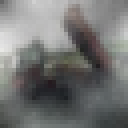

In [60]:
Image.fromarray(new_img[2]).resize((128,128))

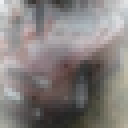

In [155]:
Image.fromarray(new_img[3]).resize((128,128))